In [1]:
!nvidia-smi

Sat Jun 12 16:48:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    36W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/My Drive/trans_learning_prac

/content/gdrive/My Drive/trans_learning_prac


In [ ]:
from inception_resnet_v1_lcl import * # 베이스 네트워크 라이브러리

# 케라스 프레임워크 라이브러리
from functools import partial
from keras.models import Model
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Concatenate
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers import Lambda
from keras.layers import MaxPooling2D
from keras.layers import add
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.applications.imagenet_utils import preprocess_input
from keras import backend as K
import numpy as np
import matplotlib.image as mpimg
from PIL import Image # opencv와 채널정보 다름에 주의
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# base_model = InceptionResNetV1(weights_path='./facenet_keras_weights.h5',
#                                input_shape=(100, 100, 3),
#                                dropout_keep_prob=0.8)
base_model = InceptionResNetV1(weights_path='./facenet_keras_weights.h5',
                               input_shape=(160, 160, 3), # input_shape=(224, 224, 3)
                               dropout_keep_prob=0.8)

In [ ]:
# 이후 학습될 부분은 뒤에 직접 추가할 것이므로 해당 부분만 학습되게 함
for layer in base_model.layers[:]:
    layer.trainable = False # 네트워크의 역전파 경로 차단 
    
base_model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

In [ ]:
# 네트워크 구성 레이어 확인용 코드
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_2
1 Conv2d_1a_3x3
2 Conv2d_1a_3x3_BatchNorm
3 Conv2d_1a_3x3_Activation
4 Conv2d_2a_3x3
5 Conv2d_2a_3x3_BatchNorm
6 Conv2d_2a_3x3_Activation
7 Conv2d_2b_3x3
8 Conv2d_2b_3x3_BatchNorm
9 Conv2d_2b_3x3_Activation
10 MaxPool_3a_3x3
11 Conv2d_3b_1x1
12 Conv2d_3b_1x1_BatchNorm
13 Conv2d_3b_1x1_Activation
14 Conv2d_4a_3x3
15 Conv2d_4a_3x3_BatchNorm
16 Conv2d_4a_3x3_Activation
17 Conv2d_4b_3x3
18 Conv2d_4b_3x3_BatchNorm
19 Conv2d_4b_3x3_Activation
20 Block35_1_Branch_2_Conv2d_0a_1x1
21 Block35_1_Branch_2_Conv2d_0a_1x1_BatchNorm
22 Block35_1_Branch_2_Conv2d_0a_1x1_Activation
23 Block35_1_Branch_1_Conv2d_0a_1x1
24 Block35_1_Branch_2_Conv2d_0b_3x3
25 Block35_1_Branch_1_Conv2d_0a_1x1_BatchNorm
26 Block35_1_Branch_2_Conv2d_0b_3x3_BatchNorm
27 Block35_1_Branch_1_Conv2d_0a_1x1_Activation
28 Block35_1_Branch_2_Conv2d_0b_3x3_Activation
29 Block35_1_Branch_0_Conv2d_1x1
30 Block35_1_Branch_1_Conv2d_0b_3x3
31 Block35_1_Branch_2_Conv2d_0c_3x3
32 Block35_1_Branch_0_Conv2d_1x1_BatchNorm
33 Block35_1_B

In [ ]:
classes = 3 # 분류하고자 하는 신원 종류 # 현태, 유성, 진호
epochs = 70
#epochs = 500
# targetx = 224
# targety = 224
targetx = 160 # 입력 영상들 해상도 통일
targety = 160


x = base_model.get_layer(index=442).output # GAP 바로 직전까지만 베이스 모델에서 가져온다
x = GlobalAveragePooling2D()(x) # GAP 추가
x = BatchNormalization()(x) # BN
x = Dropout(0.5)(x) # 드롭아웃확률 0.5 <-> 0.2
x = Dense(1024, activation='relu',  kernel_initializer='he_normal', bias_initializer='zeros')(x) # 활성화 함수 relu <-> tanh
x = BatchNormalization()(x)
x = Dropout(0.5)(x) # 드롭아웃확률 0.5 <-> 0.2
predictions = Dense(classes, activation='softmax')(x) # softmax 분류

my_model = Model(inputs=base_model.input, outputs=predictions) # customized model인 my_model 생성

my_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
____________________________________________________________________________________________

In [ ]:
# 동결한 레이어들 뒤에 새로 추가한 레이어들 잘 추가되었는 지 확인
for i, layer in enumerate(my_model.layers):
    print(i,layer.name)

0 input_2
1 Conv2d_1a_3x3
2 Conv2d_1a_3x3_BatchNorm
3 Conv2d_1a_3x3_Activation
4 Conv2d_2a_3x3
5 Conv2d_2a_3x3_BatchNorm
6 Conv2d_2a_3x3_Activation
7 Conv2d_2b_3x3
8 Conv2d_2b_3x3_BatchNorm
9 Conv2d_2b_3x3_Activation
10 MaxPool_3a_3x3
11 Conv2d_3b_1x1
12 Conv2d_3b_1x1_BatchNorm
13 Conv2d_3b_1x1_Activation
14 Conv2d_4a_3x3
15 Conv2d_4a_3x3_BatchNorm
16 Conv2d_4a_3x3_Activation
17 Conv2d_4b_3x3
18 Conv2d_4b_3x3_BatchNorm
19 Conv2d_4b_3x3_Activation
20 Block35_1_Branch_2_Conv2d_0a_1x1
21 Block35_1_Branch_2_Conv2d_0a_1x1_BatchNorm
22 Block35_1_Branch_2_Conv2d_0a_1x1_Activation
23 Block35_1_Branch_1_Conv2d_0a_1x1
24 Block35_1_Branch_2_Conv2d_0b_3x3
25 Block35_1_Branch_1_Conv2d_0a_1x1_BatchNorm
26 Block35_1_Branch_2_Conv2d_0b_3x3_BatchNorm
27 Block35_1_Branch_1_Conv2d_0a_1x1_Activation
28 Block35_1_Branch_2_Conv2d_0b_3x3_Activation
29 Block35_1_Branch_0_Conv2d_1x1
30 Block35_1_Branch_1_Conv2d_0b_3x3
31 Block35_1_Branch_2_Conv2d_0c_3x3
32 Block35_1_Branch_0_Conv2d_1x1_BatchNorm
33 Block35_1_B

In [ ]:
# 이미지 제너레이터 이용 # 프레임 워크 데이터 증강 이용
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30, # 회전
                                   width_shift_range=0.2, # 가로 shift
                                   height_shift_range=0.2, # 세로 shift
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

# setting the path of datasets
# train_dir = os.getcwd()+"/img/train_360" # 360 영상 학습 데이터셋
# val_dir = os.getcwd()+"/img/val_360" # 360 영상 검증 데이터셋
train_dir = os.getcwd()+"/img/train" # 224x224 또는 160x160 일반 영상 학습 데이터셋 경로
val_dir = os.getcwd()+"/img/val" # 224x224 또는 160x160 일반 영상 검증 데이터셋 경로

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    #batch_size=64, 
                                                    batch_size=32,
                                                    target_size=(targetx, targety), # 혹시 입력 예정 해상도와 다른 해상도 이미지 입력될 경우 resize
                                                    shuffle=True,
                                                    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(val_dir, 
                                                batch_size=8, 
                                                #batch_size=32, 
                                                target_size=(targetx, targety),
                                                shuffle=True,
                                                class_mode='categorical')

Found 671 images belonging to 3 classes.
Found 168 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/70
21/21 [==============================] - 33s 702ms/step - loss: 1.2550 - accuracy: 0.5539 - val_loss: 0.2662 - val_accuracy: 1.0000


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/70
21/21 [==============================] - 6s 278ms/step - loss: 0.2379 - accuracy: 0.9250 - val_loss: 0.1379 - val_accuracy: 1.0000
Epoch 3/70
21/21 [==============================] - 6s 277ms/step - loss: 0.1791 - accuracy: 0.9368 - val_loss: 0.0918 - val_accuracy: 1.0000
Epoch 4/70
21/21 [==============================] - 6s 272ms/step - loss: 0.1015 - accuracy: 0.9584 - val_loss: 0.0658 - val_accuracy: 1.0000
Epoch 5/70
21/21 [==============================] - 6s 273ms/step - loss: 0.1052 - accuracy: 0.9626 - val_loss: 0.0444 - val_accuracy: 1.0000
Epoch 6/70
21/21 [==============================] - 6s 285ms/step - loss: 0.1568 - accuracy: 0.9392 - val_loss: 0.0362 - val_accuracy: 1.0000
Epoch 7/70
21/21 [==============================] - 6s 266ms/step - loss: 0.1543 - accuracy: 0.9565 - val_loss: 0.0236 - val_accuracy: 1.0000
Epoch 8/70
21/21 [==============================] - 6s 267ms/step - loss: 0.0861 - accuracy: 0.9713 - val_loss: 0.0160 - val_accuracy: 1.0000
Epoch 

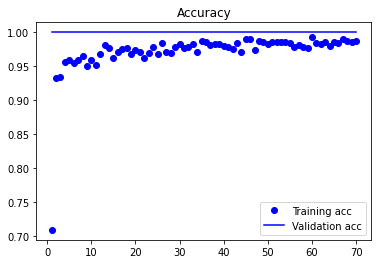

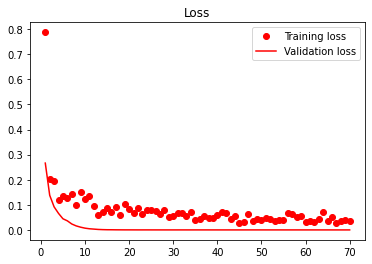

In [ ]:
# 모델 체크포인트 생성
checkpoint_dir = os.getcwd()+"/model"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint = ModelCheckpoint(filepath=checkpoint_dir+"/"+"weight_1.hdf5",
                            monitor='loss',
                            mode='min',
                            save_best_only=True) # loss가 가장 작은 경우에 대해서만 모델 갱신 및 저장 진행

optimizer = Adam(lr=0.0001) # 사전학습시 초기 lr = 0.001이므로 이론 상 0.0001 이용 # 0.001, 0.0001, 0.00001 실험 진행
loss = "categorical_crossentropy" # 크로스 엔트로피 로스 이용

my_model.compile(optimizer=optimizer,
              loss=loss,
              metrics=["accuracy"])

# 학습 진행하며 로그 기록이 history에 남게 됨
history = my_model.fit_generator(train_generator,
                                 steps_per_epoch=len(train_generator),
                                 epochs=epochs,
                                 validation_data=val_generator, 
                                 validation_steps=len(val_generator),
                                 callbacks=[checkpoint])

# train acc, train loss, val acc, val loss 기록된 것을 학습 진행하며 시각화
# val은 1 epoch가 끝날 때 마다 갱신되고, train은 1 배치가 끝날 때 마다 갱신됨
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()

### 하기는 각 경우에 대한 학습 결과 확인을 위한 코드입니다



### 학습 결과 확인하기

In [ ]:
# 모델 불러오기

import os
from keras.models import load_model

checkpoint_dir = os.getcwd()+"/model/"
model = load_model(checkpoint_dir+"0602_not_bad.hdf5") # 224x224 일반 영상으로 학습한 모델
#model = load_model(checkpoint_dir+"weight_1.hdf5") # 160x160 일반 영상으로 학습한 모델
#model = load_model(checkpoint_dir+"360_weight_1.hdf5") # 100 x100 360 영상으로 학습한 모델

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 111, 111, 32) 96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 111, 111, 32) 0           Conv2d_1a_3x3_BatchNorm[0][0]    
____________________________________________________________________________________________

In [ ]:
# test 폴더에 있는 이미지를 이용해서 인식 / 분류 실행 
import numpy as np
import matplotlib.image as mpimg
from PIL import Image
from keras.applications.imagenet_utils import preprocess_input
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline

# targetx = 224
# targety = 224
targetx = 224
targety = 224

test_dir = os.getcwd()+"/img/test_yoosung_new/"

image_path = []
for i in os.listdir(test_dir):
    test_image_name = test_dir + i
    image_path.append(test_image_name)  

cnt = 0
for image in image_path:
    img = Image.open(image)
    img = img.convert("RGB")
    img = img.resize((targetx,targety))    
    data = np.asarray(img)
    X = np.array(data)
    X = X.astype("float") / 256
    X = X.reshape(-1, targetx, targety, 3)
    categories = ["hyeontae", "jinho", "yoosung"]
    #categories = ["hyeontae", "jinho", "yoosung"]
    pred = model.predict(X)
    result = [np.argmax(value) for value in pred]   # 예측 값중 가장 높은 클래스 반환
    print()
    print('New image prediction : ',categories[result[0]])
  
    if categories[result[0]] != 'yoosung':
      cnt += 1

    print(cnt)
    print("accuracy : {}%".format(round(max(pred[0][0], pred[0][1], pred[0][2]) * 100, 2)))
    #print("accuracy : {}%".format(round(max(pred[0][0], pred[0][1], pred[0][2]) * 100, 2)))
    plt.imshow(img)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# test 폴더에 있는 이미지를 이용해서 인식 / 분류 실행 
import numpy as np
import matplotlib.image as mpimg
from PIL import Image
from keras.applications.imagenet_utils import preprocess_input
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline

# targetx = 224
# targety = 224
targetx = 224
targety = 224

test_dir = os.getcwd()+"/img/test_hyeontae/"

image_path = []
for i in os.listdir(test_dir):
    test_image_name = test_dir + i
    image_path.append(test_image_name)  

cnt = 0
for image in image_path:
    img = Image.open(image)
    img = img.convert("RGB")
    img = img.resize((targetx,targety))    
    data = np.asarray(img)
    X = np.array(data)
    X = X.astype("float") / 256
    X = X.reshape(-1, targetx, targety, 3)
    categories = ["hyeontae", "jinho", "yoosung"]
    #categories = ["hyeontae", "jinho", "yoosung"]
    pred = model.predict(X)
    result = [np.argmax(value) for value in pred]   # 예측 값중 가장 높은 클래스 반환
    print()
    print('New image prediction : ',categories[result[0]])
  
    if categories[result[0]] != 'hyeontae':
      cnt += 1

    print(cnt)
    print("accuracy : {}%".format(round(max(pred[0][0], pred[0][1], pred[0][2]) * 100, 2)))
    #print("accuracy : {}%".format(round(max(pred[0][0], pred[0][1], pred[0][2]) * 100, 2)))
    plt.imshow(img)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# test 폴더에 있는 이미지를 이용해서 인식 / 분류 실행 
import numpy as np
import matplotlib.image as mpimg
from PIL import Image
from keras.applications.imagenet_utils import preprocess_input
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline

# targetx = 224
# targety = 224
targetx = 224
targety = 224

test_dir = os.getcwd()+"/img/test_jinho/"

image_path = []
for i in os.listdir(test_dir):
    test_image_name = test_dir + i
    image_path.append(test_image_name)  

cnt = 0
for image in image_path:
    img = Image.open(image)
    img = img.convert("RGB")
    img = img.resize((targetx,targety))    
    data = np.asarray(img)
    X = np.array(data)
    X = X.astype("float") / 256
    X = X.reshape(-1, targetx, targety, 3)
    categories = ["hyeontae", "jinho", "yoosung"]
    #categories = ["hyeontae", "jinho", "yoosung"]
    pred = model.predict(X)
    result = [np.argmax(value) for value in pred]   # 예측 값중 가장 높은 클래스 반환
    print()
    print('New image prediction : ',categories[result[0]])
  
    if categories[result[0]] != 'jinho':
      cnt += 1

    print(cnt)
    print("accuracy : {}%".format(round(max(pred[0][0], pred[0][1], pred[0][2]) * 100, 2)))
    #print("accuracy : {}%".format(round(max(pred[0][0], pred[0][1], pred[0][2]) * 100, 2)))
    plt.imshow(img)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# 모델 불러오기

import os
from keras.models import load_model

checkpoint_dir = os.getcwd()+"/model/"
#model = load_model(checkpoint_dir+"0602_not_bad.hdf5") # 224x224 일반 영상으로 학습한 모델
model = load_model(checkpoint_dir+"weight_1.hdf5") # 160x160 일반 영상으로 학습한 모델
#model = load_model(checkpoint_dir+"360_weight_1.hdf5") # 100 x100 360 영상으로 학습한 모델

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
____________________________________________________________________________________________

In [ ]:
# test 폴더에 있는 이미지를 이용해서 인식 / 분류 실행 
import numpy as np
import matplotlib.image as mpimg
from PIL import Image
from keras.applications.imagenet_utils import preprocess_input
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline

# targetx = 224
# targety = 224
targetx = 160
targety = 160

test_dir = os.getcwd()+"/img/360_jinho_100100/"

image_path = []
for i in os.listdir(test_dir):
    test_image_name = test_dir + i
    image_path.append(test_image_name)  

cnt = 0
for image in image_path:
    img = Image.open(image)
    img = img.convert("RGB")
    img = img.resize((targetx,targety))    
    data = np.asarray(img)
    X = np.array(data)
    X = X.astype("float") / 256
    X = X.reshape(-1, targetx, targety, 3)
    categories = ["hyeontae", "jinho", "yoosung"]
    #categories = ["hyeontae", "jinho", "yoosung"]
    pred = model.predict(X)
    result = [np.argmax(value) for value in pred]   # 예측 값중 가장 높은 클래스 반환
    print()
    print('New image prediction : ',categories[result[0]])
  
    if categories[result[0]] != 'jinho':
      cnt += 1

    print(cnt)
    print("accuracy : {}%".format(round(max(pred[0][0], pred[0][1], pred[0][2]) * 100, 2)))
    #print("accuracy : {}%".format(round(max(pred[0][0], pred[0][1], pred[0][2]) * 100, 2)))
    plt.imshow(img)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# test 폴더에 있는 이미지를 이용해서 인식 / 분류 실행 
import numpy as np
import matplotlib.image as mpimg
from PIL import Image
from keras.applications.imagenet_utils import preprocess_input
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline

# targetx = 224
# targety = 224
targetx = 160
targety = 160

test_dir = os.getcwd()+"/img/360_hyeontae_100100/"

image_path = []
for i in os.listdir(test_dir):
    test_image_name = test_dir + i
    image_path.append(test_image_name)  

cnt = 0
for image in image_path:
    img = Image.open(image)
    img = img.convert("RGB")
    img = img.resize((targetx,targety))    
    data = np.asarray(img)
    X = np.array(data)
    X = X.astype("float") / 256
    X = X.reshape(-1, targetx, targety, 3)
    categories = ["hyeontae", "jinho", "yoosung"]
    #categories = ["hyeontae", "jinho", "yoosung"]
    pred = model.predict(X)
    result = [np.argmax(value) for value in pred]   # 예측 값중 가장 높은 클래스 반환
    print()
    print('New image prediction : ',categories[result[0]])
  
    if categories[result[0]] != 'hyeontae':
      cnt += 1

    print(cnt)
    print("accuracy : {}%".format(round(max(pred[0][0], pred[0][1], pred[0][2]) * 100, 2)))
    #print("accuracy : {}%".format(round(max(pred[0][0], pred[0][1], pred[0][2]) * 100, 2)))
    plt.imshow(img)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# test 폴더에 있는 이미지를 이용해서 인식 / 분류 실행 
import numpy as np
import matplotlib.image as mpimg
from PIL import Image
from keras.applications.imagenet_utils import preprocess_input
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline

# targetx = 224
# targety = 224
targetx = 160
targety = 160

test_dir = os.getcwd()+"/img/360_yoosung_100100/"

image_path = []
for i in os.listdir(test_dir):
    test_image_name = test_dir + i
    image_path.append(test_image_name)  

cnt = 0
for image in image_path:
    img = Image.open(image)
    img = img.convert("RGB")
    img = img.resize((targetx,targety))    
    data = np.asarray(img)
    X = np.array(data)
    X = X.astype("float") / 256
    X = X.reshape(-1, targetx, targety, 3)
    categories = ["hyeontae", "jinho", "yoosung"]
    #categories = ["hyeontae", "jinho", "yoosung"]
    pred = model.predict(X)
    result = [np.argmax(value) for value in pred]   # 예측 값중 가장 높은 클래스 반환
    print()
    print('New image prediction : ',categories[result[0]])
  
    if categories[result[0]] != 'yoosung':
      cnt += 1

    print(cnt)
    print("accuracy : {}%".format(round(max(pred[0][0], pred[0][1], pred[0][2]) * 100, 2)))
    #print("accuracy : {}%".format(round(max(pred[0][0], pred[0][1], pred[0][2]) * 100, 2)))
    plt.imshow(img)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# test 폴더에 있는 이미지를 이용해서 인식 / 분류 실행 
import numpy as np
import matplotlib.image as mpimg
from PIL import Image
from keras.applications.imagenet_utils import preprocess_input
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline

# targetx = 224
# targety = 224
targetx = 160
targety = 160

test_dir = os.getcwd()+"/img/test_jinho/"

image_path = []
for i in os.listdir(test_dir):
    test_image_name = test_dir + i
    image_path.append(test_image_name)  

cnt = 0
for image in image_path:
    img = Image.open(image)
    img = img.convert("RGB")
    img = img.resize((targetx,targety))    
    data = np.asarray(img)
    X = np.array(data)
    X = X.astype("float") / 256
    X = X.reshape(-1, targetx, targety, 3)
    categories = ["hyeontae", "jinho", "yoosung"]
    #categories = ["hyeontae", "jinho", "yoosung"]
    pred = model.predict(X)
    result = [np.argmax(value) for value in pred]   # 예측 값중 가장 높은 클래스 반환
    print()
    print('New image prediction : ',categories[result[0]])
  
    if categories[result[0]] != 'jinho':
      cnt += 1

    print(cnt)
    print("accuracy : {}%".format(round(max(pred[0][0], pred[0][1], pred[0][2]) * 100, 2)))
    #print("accuracy : {}%".format(round(max(pred[0][0], pred[0][1], pred[0][2]) * 100, 2)))
    plt.imshow(img)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# test 폴더에 있는 이미지를 이용해서 인식 / 분류 실행 
import numpy as np
import matplotlib.image as mpimg
from PIL import Image
from keras.applications.imagenet_utils import preprocess_input
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline

# targetx = 224
# targety = 224
targetx = 160
targety = 160

test_dir = os.getcwd()+"/img/test_hyeontae/"

image_path = []
for i in os.listdir(test_dir):
    test_image_name = test_dir + i
    image_path.append(test_image_name)  

cnt = 0
for image in image_path:
    img = Image.open(image)
    img = img.convert("RGB")
    img = img.resize((targetx,targety))    
    data = np.asarray(img)
    X = np.array(data)
    X = X.astype("float") / 256
    X = X.reshape(-1, targetx, targety, 3)
    categories = ["hyeontae", "jinho", "yoosung"]
    #categories = ["hyeontae", "jinho", "yoosung"]
    pred = model.predict(X)
    result = [np.argmax(value) for value in pred]   # 예측 값중 가장 높은 클래스 반환
    print()
    print('New image prediction : ',categories[result[0]])
  
    if categories[result[0]] != 'hyeontae':
      cnt += 1

    print(cnt)
    print("accuracy : {}%".format(round(max(pred[0][0], pred[0][1], pred[0][2]) * 100, 2)))
    #print("accuracy : {}%".format(round(max(pred[0][0], pred[0][1], pred[0][2]) * 100, 2)))
    plt.imshow(img)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# test 폴더에 있는 이미지를 이용해서 인식 / 분류 실행 
import numpy as np
import matplotlib.image as mpimg
from PIL import Image
from keras.applications.imagenet_utils import preprocess_input
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline

# targetx = 224
# targety = 224
targetx = 160
targety = 160

test_dir = os.getcwd()+"/img/test_yoosung/"

image_path = []
for i in os.listdir(test_dir):
    test_image_name = test_dir + i
    image_path.append(test_image_name)  

cnt = 0
for image in image_path:
    img = Image.open(image)
    img = img.convert("RGB")
    img = img.resize((targetx,targety))    
    data = np.asarray(img)
    X = np.array(data)
    X = X.astype("float") / 256
    X = X.reshape(-1, targetx, targety, 3)
    categories = ["hyeontae", "jinho", "yoosung"]
    #categories = ["hyeontae", "jinho", "yoosung"]
    pred = model.predict(X)
    result = [np.argmax(value) for value in pred]   # 예측 값중 가장 높은 클래스 반환
    print()
    print('New image prediction : ',categories[result[0]])
  
    if categories[result[0]] != 'yoosung':
      cnt += 1

    print(cnt)
    print("accuracy : {}%".format(round(max(pred[0][0], pred[0][1], pred[0][2]) * 100, 2)))
    #print("accuracy : {}%".format(round(max(pred[0][0], pred[0][1], pred[0][2]) * 100, 2)))
    plt.imshow(img)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# 모델 불러오기

import os
from keras.models import load_model

checkpoint_dir = os.getcwd()+"/model/"
#model = load_model(checkpoint_dir+"0602_not_bad.hdf5") # 224x224 일반 영상으로 학습한 모델
#model = load_model(checkpoint_dir+"weight_1.hdf5") # 160x160 일반 영상으로 학습한 모델
model = load_model(checkpoint_dir+"360_weight_1.hdf5") # 100 x100 360 영상으로 학습한 모델

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 49, 49, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 49, 49, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 49, 49, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
______________________________________________________________________________________________

In [ ]:
# test 폴더에 있는 이미지를 이용해서 인식 / 분류 실행 
import numpy as np
import matplotlib.image as mpimg
from PIL import Image
from keras.applications.imagenet_utils import preprocess_input
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline

# targetx = 224
# targety = 224
targetx = 100
targety = 100

test_dir = os.getcwd()+"/img/360_hyeontae_100100/"

image_path = []
for i in os.listdir(test_dir):
    test_image_name = test_dir + i
    image_path.append(test_image_name)  

cnt = 0
for image in image_path:
    img = Image.open(image)
    img = img.convert("RGB")
    img = img.resize((targetx,targety))    
    data = np.asarray(img)
    X = np.array(data)
    X = X.astype("float") / 256
    X = X.reshape(-1, targetx, targety, 3)
    categories = ["hyeontae", "jinho", "yoosung"]
    #categories = ["hyeontae", "jinho", "yoosung"]
    pred = model.predict(X)
    result = [np.argmax(value) for value in pred]   # 예측 값중 가장 높은 클래스 반환
    print()
    print('New image prediction : ',categories[result[0]])
  
    if categories[result[0]] != 'hyeontae':
      cnt += 1

    print(cnt)
    print("accuracy : {}%".format(round(max(pred[0][0], pred[0][1], pred[0][2]) * 100, 2)))
    #print("accuracy : {}%".format(round(max(pred[0][0], pred[0][1], pred[0][2]) * 100, 2)))
    plt.imshow(img)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# test 폴더에 있는 이미지를 이용해서 인식 / 분류 실행 
import numpy as np
import matplotlib.image as mpimg
from PIL import Image
from keras.applications.imagenet_utils import preprocess_input
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline

# targetx = 224
# targety = 224
targetx = 100
targety = 100

test_dir = os.getcwd()+"/img/360_jinho_100100/"

image_path = []
for i in os.listdir(test_dir):
    test_image_name = test_dir + i
    image_path.append(test_image_name)  

cnt = 0
for image in image_path:
    img = Image.open(image)
    img = img.convert("RGB")
    img = img.resize((targetx,targety))    
    data = np.asarray(img)
    X = np.array(data)
    X = X.astype("float") / 256
    X = X.reshape(-1, targetx, targety, 3)
    categories = ["hyeontae", "jinho", "yoosung"]
    #categories = ["hyeontae", "jinho", "yoosung"]
    pred = model.predict(X)
    result = [np.argmax(value) for value in pred]   # 예측 값중 가장 높은 클래스 반환
    print()
    print('New image prediction : ',categories[result[0]])
  
    if categories[result[0]] != 'jinho':
      cnt += 1

    print(cnt)
    print("accuracy : {}%".format(round(max(pred[0][0], pred[0][1], pred[0][2]) * 100, 2)))
    #print("accuracy : {}%".format(round(max(pred[0][0], pred[0][1], pred[0][2]) * 100, 2)))
    plt.imshow(img)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# test 폴더에 있는 이미지를 이용해서 인식 / 분류 실행 
import numpy as np
import matplotlib.image as mpimg
from PIL import Image
from keras.applications.imagenet_utils import preprocess_input
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline

# targetx = 224
# targety = 224
targetx = 100
targety = 100

test_dir = os.getcwd()+"/img/360_yoosung_100100/"

image_path = []
for i in os.listdir(test_dir):
    test_image_name = test_dir + i
    image_path.append(test_image_name)  

cnt = 0
for image in image_path:
    img = Image.open(image)
    img = img.convert("RGB")
    img = img.resize((targetx,targety))    
    data = np.asarray(img)
    X = np.array(data)
    X = X.astype("float") / 256
    X = X.reshape(-1, targetx, targety, 3)
    categories = ["hyeontae", "jinho", "yoosung"]
    #categories = ["hyeontae", "jinho", "yoosung"]
    pred = model.predict(X)
    result = [np.argmax(value) for value in pred]   # 예측 값중 가장 높은 클래스 반환
    print()
    print('New image prediction : ',categories[result[0]])
  
    if categories[result[0]] != 'yoosung':
      cnt += 1

    print(cnt)
    print("accuracy : {}%".format(round(max(pred[0][0], pred[0][1], pred[0][2]) * 100, 2)))
    #print("accuracy : {}%".format(round(max(pred[0][0], pred[0][1], pred[0][2]) * 100, 2)))
    plt.imshow(img)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.